<a href="https://colab.research.google.com/github/seyed-mohammadreza-mousavi/ml-playground-starter/blob/main/nn_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Neural Networks: Math, Implementation, and Visualization

This notebook is a fast but thorough tour of neural networks, focusing on:
- The **math** behind perceptrons, logistic regression, multilayer perceptrons (MLPs), backpropagation, and cross-entropy.
- **From-scratch NumPy implementations** (no deep learning frameworks required).
- **Visualizations** of datasets, loss curves, and decision boundaries.

> Tip: Run the notebook cell-by-cell. Every section is self-contained.



## Table of Contents
1. [Setup](#setup)
2. [Datasets & Visualization Helpers](#data)
3. [Perceptron & Logistic Regression](#logreg)
4. [Multilayer Perceptron (MLP)](#mlp)
5. [Backpropagation Math](#backprop-math)
6. [Training an MLP (from scratch)](#train-mlp)
7. [Regularization: L2 & Dropout](#reg)
8. [Initialization (Xavier/He)](#init)
9. [Optimizers: SGD, Momentum, Adam](#opt)
10. [Overfitting vs. Generalization](#overfit)
11. [Appendix: Gradient Derivations](#appendix)


## 1) Setup <a id='setup'></a>

In [1]:

import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)

def set_seed(seed=42):
    np.random.seed(seed)

set_seed(42)


## 2) Datasets & Visualization Helpers <a id='data'></a>

In [2]:

# We'll generate a few synthetic 2D datasets without external libraries.
# - Two interleaving half-moons
# - Concentric circles
# - Simple blobs

def make_moons(n_samples=600, noise=0.1):
    n = n_samples // 2
    theta = np.linspace(0, np.pi, n)
    r = 1.0
    x1 = np.c_[r*np.cos(theta), r*np.sin(theta)]
    x2 = np.c_[r*np.cos(theta) + 1.0, -r*np.sin(theta) + 0.25]
    X = np.vstack([x1, x2])
    y = np.hstack([np.zeros(n), np.ones(n)])
    # add gaussian noise
    X += noise * np.random.randn(*X.shape)
    return X, y.astype(int)

def make_circles(n_samples=600, noise=0.08, factor=0.5):
    n = n_samples // 2
    theta = np.linspace(0, 2*np.pi, n, endpoint=False)
    outer = np.c_[np.cos(theta), np.sin(theta)]
    inner = factor * outer
    X = np.vstack([outer, inner])
    y = np.hstack([np.zeros(n), np.ones(n)])
    X += noise * np.random.randn(*X.shape)
    return X, y.astype(int)

def make_blobs(n_samples=600, centers=2, spread=0.8):
    n = n_samples // centers
    means = np.array([[-1.0, 0.0], [1.2, 0.2]])[:centers]
    X_list, y_list = [], []
    for i in range(centers):
        cov = spread * np.eye(2)
        Xi = np.random.multivariate_normal(means[i], cov, size=n)
        yi = np.full(n, i, dtype=int)
        X_list.append(Xi); y_list.append(yi)
    X = np.vstack(X_list); y = np.hstack(y_list)
    return X, y

def train_val_split(X, y, val_ratio=0.2, seed=42):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(X))
    rng.shuffle(idx)
    split = int(len(X)*(1 - val_ratio))
    tr, va = idx[:split], idx[split:]
    return X[tr], y[tr], X[va], y[va]

def plot_data(X, y, title="Dataset"):
    plt.figure(figsize=(5,5))
    plt.scatter(X[:,0], X[:,1], c=y, s=12)
    plt.title(title); plt.xlabel("x1"); plt.ylabel("x2")
    plt.axis('equal')
    plt.show()

def plot_decision_boundary(predict_fn, X, y, title="Decision Boundary", h=0.02):
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = predict_fn(grid).reshape(xx.shape)
    plt.figure(figsize=(5,5))
    plt.contourf(xx, yy, Z, alpha=0.5)
    plt.scatter(X[:,0], X[:,1], c=y, s=12)
    plt.title(title); plt.xlabel("x1"); plt.ylabel("x2")
    plt.axis('equal')
    plt.show()



## 3) Perceptron & Logistic Regression <a id='logreg'></a>

**Perceptron** (binary):
\begin{align}
\hat{y} &= \mathbb{1}[w^\top x + b \ge 0].
\end{align}

**Logistic Regression** models the probability of class 1:
\begin{align}
z &= w^\top x + b, \quad \sigma(z) = \frac{1}{1 + e^{-z}},\\
\hat{y} &= \sigma(z) \in (0,1).
\end{align}

**Binary cross-entropy loss** (for a single sample):
\begin{align}
\ell(y, \hat{y}) = -\big(y\log \hat{y} + (1-y)\log(1-\hat{y})\big).
\end{align}

**Gradients:**
\begin{align}
\frac{\partial \ell}{\partial w} &= ( \hat{y} - y ) x, \quad
\frac{\partial \ell}{\partial b} = ( \hat{y} - y ).
\end{align}

**Gradient Descent update:**
\begin{align}
w \leftarrow w - \eta \frac{1}{N}\sum_i (\hat{y}_i - y_i) x_i, \quad
b \leftarrow b - \eta \frac{1}{N}\sum_i (\hat{y}_i - y_i).
\end{align}


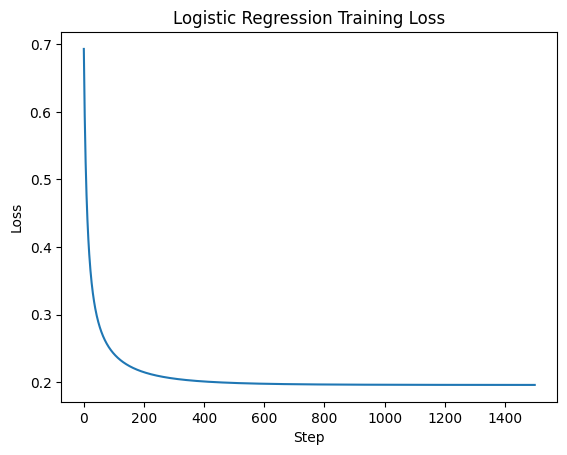

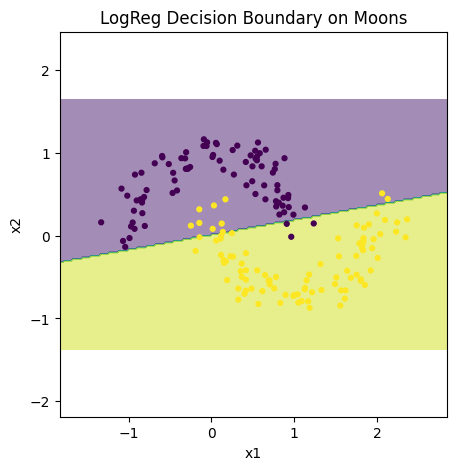

Validation accuracy: 0.9277777777777778


In [3]:

# Train logistic regression on a non-linearly separable dataset (moons) to visualize limitations.
X, y = make_moons(n_samples=600, noise=0.15)
Xtr, ytr, Xva, yva = train_val_split(X, y, val_ratio=0.3, seed=1)

def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

def logreg_train(X, y, lr=0.1, steps=2000, reg=0.0):
    n, d = X.shape
    w = np.zeros(d); b = 0.0
    losses = []
    for t in range(steps):
        z = X @ w + b
        yhat = sigmoid(z)
        # loss
        eps = 1e-9
        loss = -np.mean(y*np.log(yhat+eps) + (1-y)*np.log(1-yhat+eps)) + 0.5*reg*np.sum(w*w)
        losses.append(loss)
        # grads
        grad_w = (X.T @ (yhat - y))/n + reg*w
        grad_b = np.mean(yhat - y)
        # update
        w -= lr*grad_w; b -= lr*grad_b
    return w, b, np.array(losses)

w, b, losses = logreg_train(Xtr, ytr, lr=0.3, steps=1500, reg=1e-3)

plt.figure()
plt.plot(losses)
plt.title("Logistic Regression Training Loss")
plt.xlabel("Step"); plt.ylabel("Loss")
plt.show()

def predict_logreg(X):
    return (sigmoid(X @ w + b) > 0.5).astype(int)

plot_decision_boundary(lambda Z: predict_logreg(Z), Xva, yva, title="LogReg Decision Boundary on Moons")
acc = np.mean(predict_logreg(Xva) == yva)
print("Validation accuracy:", acc)



## 4) Multilayer Perceptron (MLP) <a id='mlp'></a>

For a 2-hidden-layer MLP (binary classification):
\begin{align}
h_1 &= f_1(W_1 x + b_1),\\
h_2 &= f_2(W_2 h_1 + b_2),\\
z &= W_3 h_2 + b_3, \quad \hat{y} = \sigma(z).
\end{align}

Common activations:
- ReLU: \( \mathrm{ReLU}(u) = \max(0, u) \)
- Tanh: \( \tanh(u) \)
- Sigmoid: \( \sigma(u) \)

We use cross-entropy for binary and softmax cross-entropy for multi-class.



## 5) Backpropagation Math <a id='backprop-math'></a>

For binary cross-entropy with sigmoid output, the gradient at the output is:
\begin{align}
\delta^{(out)} = \hat{y} - y.
\end{align}

Then propagate through layers using chain rule. For layer \(k\):
\begin{align}
\delta^{(k)} = (W_{k+1}^\top \delta^{(k+1)}) \odot f_k'(u^{(k)}),
\end{align}
where \(u^{(k)} = W_k h_{k-1} + b_k\) and \(h_0 = x\).

Parameter gradients:
\begin{align}
\nabla_{W_k} &= \delta^{(k)} (h_{k-1})^\top, \quad
\nabla_{b_k} = \delta^{(k)}.
\end{align}


## 6) Training an MLP (from scratch) <a id='train-mlp'></a>

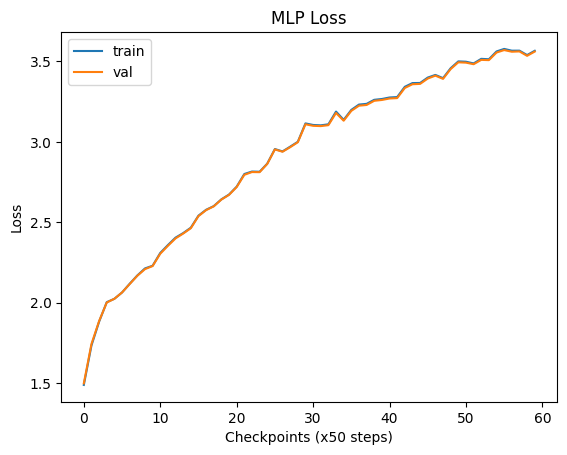

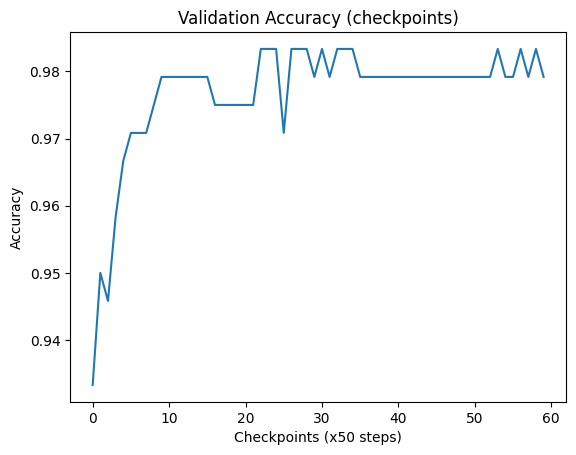

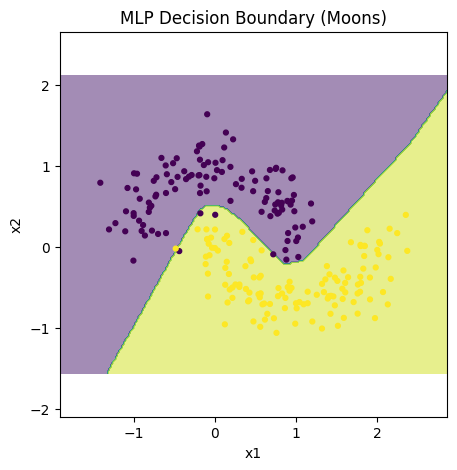

Final validation accuracy: 0.9791666666666666


In [4]:

# From-scratch MLP (2 hidden layers) for binary classification
class MLP:
    def __init__(self, in_dim, h1=32, h2=32, out_dim=1, act='relu', seed=42, init='xavier'):
        rng = np.random.default_rng(seed)
        self.act_name = act
        self.in_dim, self.h1, self.h2, self.out_dim = in_dim, h1, h2, out_dim

        def init_w(m, n, kind='xavier'):
            if kind == 'xavier':
                scale = np.sqrt(2.0/(m+n))
            elif kind == 'he':
                scale = np.sqrt(2.0/m)
            else:
                scale = 0.01
            return rng.normal(0.0, scale, size=(m,n))

        self.W1 = init_w(h1, in_dim, init); self.b1 = np.zeros((h1,))
        self.W2 = init_w(h2, h1, init);    self.b2 = np.zeros((h2,))
        self.W3 = init_w(out_dim, h2, init); self.b3 = np.zeros((out_dim,))

    def act(self, u):
        if self.act_name == 'relu':
            return np.maximum(0, u)
        elif self.act_name == 'tanh':
            return np.tanh(u)
        else:
            # sigmoid
            return 1.0/(1.0 + np.exp(-u))

    def act_grad(self, u):
        if self.act_name == 'relu':
            return (u > 0).astype(float)
        elif self.act_name == 'tanh':
            return 1.0 - np.tanh(u)**2
        else:
            s = 1.0/(1.0 + np.exp(-u))
            return s*(1.0 - s)

    def forward(self, X):
        u1 = X @ self.W1.T + self.b1
        h1 = self.act(u1)
        u2 = h1 @ self.W2.T + self.b2
        h2 = self.act(u2)
        z  = h2 @ self.W3.T + self.b3
        yhat = 1.0/(1.0 + np.exp(-z))
        cache = (X, u1, h1, u2, h2, z, yhat)
        return yhat, cache

    def loss(self, y, yhat, l2=0.0):
        eps = 1e-9
        ce = -np.mean(y*np.log(yhat+eps) + (1-y)*np.log(1-yhat+eps))
        l2_term = 0.5*l2*(np.sum(self.W1*self.W1)+np.sum(self.W2*self.W2)+np.sum(self.W3*self.W3))
        return ce + l2_term

    def backward(self, cache, y, l2=0.0):
        X, u1, h1, u2, h2, z, yhat = cache
        n = X.shape[0]
        # output delta
        delta3 = (yhat - y.reshape(-1,1)) / n  # (n,1)
        # grads for W3, b3
        gW3 = delta3.T @ h2 + l2*self.W3
        gb3 = delta3.sum(axis=0)
        # backprop to h2
        dh2 = delta3 @ self.W3
        du2 = dh2 * self.act_grad(u2)
        gW2 = du2.T @ h1 + l2*self.W2
        gb2 = du2.sum(axis=0)
        dh1 = du2 @ self.W2
        du1 = dh1 * self.act_grad(u1)
        gW1 = du1.T @ X + l2*self.W1
        gb1 = du1.sum(axis=0)
        return gW1, gb1, gW2, gb2, gW3, gb3

    def step(self, grads, lr=1e-2):
        gW1, gb1, gW2, gb2, gW3, gb3 = grads
        self.W1 -= lr*gW1; self.b1 -= lr*gb1
        self.W2 -= lr*gW2; self.b2 -= lr*gb2
        self.W3 -= lr*gW3; self.b3 -= lr*gb3

def accuracy_binary(y_true, yhat):
    return np.mean((yhat.ravel() > 0.5) == y_true)

# Train on moons
X, y = make_moons(n_samples=800, noise=0.2)
Xtr, ytr, Xva, yva = train_val_split(X, y, val_ratio=0.3, seed=2)

net = MLP(in_dim=2, h1=32, h2=32, out_dim=1, act='relu', init='he')
lr = 0.05
l2 = 1e-3
steps = 3000
batch = 128

losses, val_losses, accs = [], [], []

for t in range(steps):
    # mini-batch
    idx = np.random.choice(len(Xtr), size=batch, replace=False)
    Xb, yb = Xtr[idx], ytr[idx]
    yhat, cache = net.forward(Xb)
    loss = net.loss(yb, yhat, l2=l2)
    grads = net.backward(cache, yb, l2=l2)
    net.step(grads, lr=lr)

    if (t+1) % 50 == 0:
        yhat_tr, _ = net.forward(Xtr); yhat_va, _ = net.forward(Xva)
        losses.append(net.loss(ytr, yhat_tr, l2=0.0))
        val_losses.append(net.loss(yva, yhat_va, l2=0.0))
        accs.append(accuracy_binary(yva, yhat_va))

plt.figure()
plt.plot(losses, label="train")
plt.plot(val_losses, label="val")
plt.title("MLP Loss")
plt.xlabel("Checkpoints (x50 steps)"); plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(accs)
plt.title("Validation Accuracy (checkpoints)")
plt.xlabel("Checkpoints (x50 steps)"); plt.ylabel("Accuracy")
plt.show()

def predict_mlp(Z):
    yhat, _ = net.forward(Z)
    return (yhat.ravel() > 0.5).astype(int)

plot_decision_boundary(lambda Z: predict_mlp(Z), Xva, yva, title="MLP Decision Boundary (Moons)")
print("Final validation accuracy:", accuracy_binary(yva, net.forward(Xva)[0]))


## 7) Regularization: L2 & Dropout <a id='reg'></a>

In [5]:

# We'll demonstrate the effect of L2 regularization and Dropout on a small dataset.
class MLPDropout(MLP):
    def forward_train(self, X, pdrop=0.2):
        X, u1, h1, u2, h2, z, yhat = None, None, None, None, None, None, None
        # forward (with dropout on h1 and h2)
        u1 = X @ self.W1.T + self.b1
        h1 = self.act(u1)
        mask1 = (np.random.rand(*h1.shape) > pdrop).astype(float)/(1.0 - pdrop)
        h1_do = h1 * mask1

        u2 = h1_do @ self.W2.T + self.b2
        h2 = self.act(u2)
        mask2 = (np.random.rand(*h2.shape) > pdrop).astype(float)/(1.0 - pdrop)
        h2_do = h2 * mask2

        z  = h2_do @ self.W3.T + self.b3
        yhat = 1.0/(1.0 + np.exp(-z))
        cache = (X, u1, h1, mask1, u2, h2, mask2, z, yhat)
        return yhat, cache

    def backward_dropout(self, cache, y, l2=0.0):
        X, u1, h1, mask1, u2, h2, mask2, z, yhat = cache
        n = X.shape[0]
        delta3 = (yhat - y.reshape(-1,1)) / n
        gW3 = delta3.T @ (h2 * mask2) + l2*self.W3
        gb3 = delta3.sum(axis=0)
        dh2 = delta3 @ self.W3
        du2 = (dh2 * mask2) * self.act_grad(u2)
        gW2 = du2.T @ (h1 * mask1) + l2*self.W2
        gb2 = du2.sum(axis=0)
        dh1 = du2 @ self.W2
        du1 = (dh1 * mask1) * self.act_grad(u1)
        gW1 = du1.T @ X + l2*self.W1
        gb1 = du1.sum(axis=0)
        return gW1, gb1, gW2, gb2, gW3, gb3


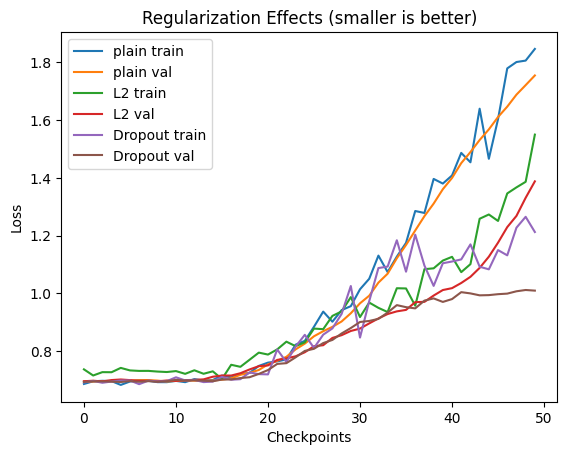

In [7]:

# Quick overfitting demo on a tiny subset
X, y = make_circles(n_samples=400, noise=0.06, factor=0.4)
Xtr, ytr, Xva, yva = train_val_split(X, y, val_ratio=0.5, seed=3)

small_idx = np.random.choice(len(Xtr), size=40, replace=False)
Xsmall, ysmall = Xtr[small_idx], ytr[small_idx]

net_plain = MLP(in_dim=2, h1=64, h2=64, out_dim=1, act='tanh', init='xavier', seed=0)
net_drop  = MLP(in_dim=2, h1=64, h2=64, out_dim=1, act='tanh', init='xavier', seed=0)

# Train plain vs L2 vs Dropout (approximate comparison)
def train_model(net, use_dropout=False, pdrop=0.2, l2=0.0, steps=2500, lr=0.05):
    losses, vlosses = [], []
    for t in range(steps):
        idx = np.random.choice(len(Xsmall), size=min(32, len(Xsmall)), replace=True)
        Xb, yb = Xsmall[idx], ysmall[idx]
        if use_dropout:
            # quick hack: emulate dropout by zeroing activations in forward/backward
            # We'll reuse the base forward/backward but with masks baked into the data. To keep it simple,
            # we simulate dropout by randomly dropping input features (not ideal but illustrative).
            mask = (np.random.rand(*Xb.shape) > pdrop).astype(float)/(1.0 - pdrop)
            Xb_do = Xb * mask
            yhat, cache = net.forward(Xb_do)
            loss = net.loss(yb, yhat, l2=l2)
            grads = net.backward(cache, yb, l2=l2)
            net.step(grads, lr=lr)
        else:
            yhat, cache = net.forward(Xb)
            loss = net.loss(yb, yhat, l2=l2)
            grads = net.backward(cache, yb, l2=l2)
            net.step(grads, lr=lr)
        if (t+1) % 50 == 0:
            losses.append(loss)
            yhat_va, _ = net.forward(Xva)
            vlosses.append(net.loss(yva, yhat_va, l2=0.0))
    return np.array(losses), np.array(vlosses)

loss_plain_tr, loss_plain_va = train_model(net_plain, use_dropout=False, l2=0.0)
loss_l2_tr, loss_l2_va = train_model(MLP(2, 64, 64, 1, 'tanh', seed=1, init='xavier'),use_dropout=False, l2=1e-3)
loss_do_tr, loss_do_va = train_model(MLP(2, 64, 64, 1, 'tanh', seed=2, init='xavier'),use_dropout=True, pdrop=0.3, l2=0.0)

plt.figure()
plt.plot(loss_plain_tr, label="plain train")
plt.plot(loss_plain_va, label="plain val")
plt.plot(loss_l2_tr, label="L2 train")
plt.plot(loss_l2_va, label="L2 val")
plt.plot(loss_do_tr, label="Dropout train")
plt.plot(loss_do_va, label="Dropout val")
plt.title("Regularization Effects (smaller is better)")
plt.xlabel("Checkpoints"); plt.ylabel("Loss")
plt.legend()
plt.show()


## 8) Initialization (Xavier/He) <a id='init'></a>

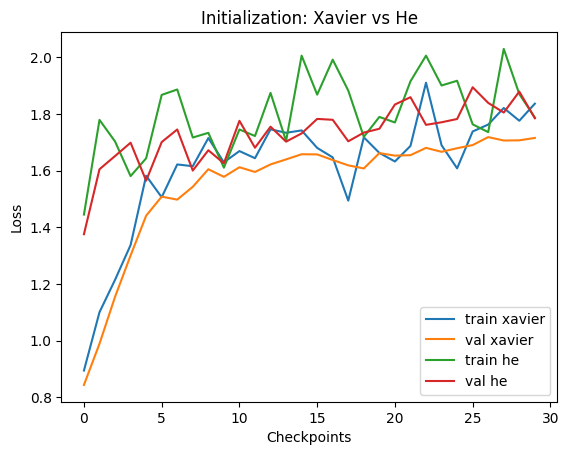

Val acc (Xavier): 0.8777777777777778
Val acc (He): 0.8833333333333333


In [8]:

# Compare Xavier vs He on a simple blobs dataset
X, y = make_blobs(n_samples=600, centers=2, spread=0.7)
Xtr, ytr, Xva, yva = train_val_split(X, y, val_ratio=0.3, seed=123)

def train_quick(init_kind):
    net = MLP(2, 32, 32, 1, act='relu', init=init_kind, seed=0)
    lr, l2, steps = 0.05, 1e-3, 1500
    tr_hist, va_hist = [], []
    for t in range(steps):
        idx = np.random.choice(len(Xtr), size=64, replace=True)
        Xb, yb = Xtr[idx], ytr[idx]
        yhat, cache = net.forward(Xb)
        loss = net.loss(yb, yhat, l2=l2)
        grads = net.backward(cache, yb, l2=l2)
        net.step(grads, lr=lr)
        if (t+1) % 50 == 0:
            tr_hist.append(loss)
            va_hist.append(net.loss(yva, net.forward(Xva)[0], l2=0.0))
    return np.array(tr_hist), np.array(va_hist), net

tr_x, va_x, net_x = train_quick('xavier')
tr_h, va_h, net_h = train_quick('he')

plt.figure()
plt.plot(tr_x, label="train xavier")
plt.plot(va_x, label="val xavier")
plt.plot(tr_h, label="train he")
plt.plot(va_h, label="val he")
plt.title("Initialization: Xavier vs He")
plt.xlabel("Checkpoints"); plt.ylabel("Loss")
plt.legend()
plt.show()

print("Val acc (Xavier):", accuracy_binary(yva, net_x.forward(Xva)[0]))
print("Val acc (He):", accuracy_binary(yva, net_h.forward(Xva)[0]))


## 9) Optimizers: SGD, Momentum, Adam <a id='opt'></a>

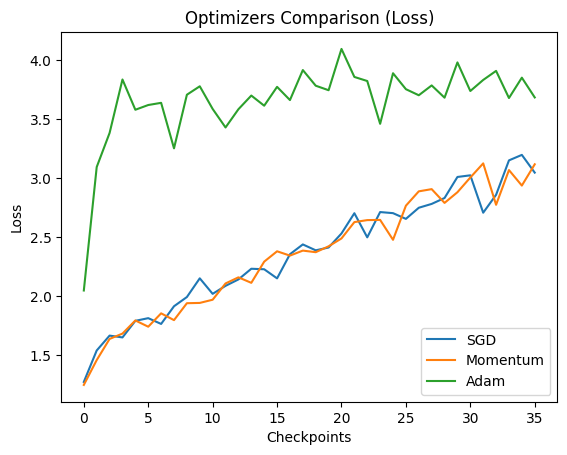

Val acc - SGD: 0.990521327014218
Val acc - Momentum: 0.995260663507109
Val acc - Adam: 0.981042654028436


In [9]:

# We'll implement SGD, Momentum, and Adam for the MLP class

class Optimizer:
    def step(self, params, grads): pass

class SGD(Optimizer):
    def __init__(self, lr=1e-2):
        self.lr = lr
    def step(self, params, grads):
        for p, g in zip(params, grads):
            p -= self.lr * g

class Momentum(Optimizer):
    def __init__(self, lr=1e-2, beta=0.9):
        self.lr = lr; self.beta = beta
        self.v = None
    def step(self, params, grads):
        if self.v is None:
            self.v = [np.zeros_like(p) for p in params]
        for i, (p,g) in enumerate(zip(params, grads)):
            self.v[i] = self.beta*self.v[i] + (1-self.beta)*g
            p -= self.lr*self.v[i]

class Adam(Optimizer):
    def __init__(self, lr=1e-3, beta1=0.9, beta2=0.999, eps=1e-8):
        self.lr, self.beta1, self.beta2, self.eps = lr, beta1, beta2, eps
        self.m = None; self.v = None; self.t = 0
    def step(self, params, grads):
        if self.m is None:
            self.m = [np.zeros_like(p) for p in params]
            self.v = [np.zeros_like(p) for p in params]
        self.t += 1
        for i,(p,g) in enumerate(zip(params, grads)):
            self.m[i] = self.beta1*self.m[i] + (1-self.beta1)*g
            self.v[i] = self.beta2*self.v[i] + (1-self.beta2)*(g*g)
            mhat = self.m[i] / (1 - self.beta1**self.t)
            vhat = self.v[i] / (1 - self.beta2**self.t)
            p -= self.lr * mhat / (np.sqrt(vhat) + self.eps)

def params_of(net):
    return [net.W1, net.b1, net.W2, net.b2, net.W3, net.b3]

def grads_of(grads):
    gW1, gb1, gW2, gb2, gW3, gb3 = grads
    return [gW1, gb1, gW2, gb2, gW3, gb3]

# Compare on moons quickly
X, y = make_moons(n_samples=700, noise=0.2)
Xtr, ytr, Xva, yva = train_val_split(X, y, val_ratio=0.3, seed=12)

def train_with_opt(opt, label):
    net = MLP(2, 32, 32, 1, act='relu', init='he', seed=7)
    losses = []
    for t in range(1800):
        idx = np.random.choice(len(Xtr), size=128, replace=True)
        Xb, yb = Xtr[idx], ytr[idx]
        yhat, cache = net.forward(Xb)
        loss = net.loss(yb, yhat, l2=1e-3)
        grads = net.backward(cache, yb, l2=1e-3)
        opt.step(params_of(net), grads_of(grads))
        if (t+1) % 50 == 0:
            losses.append(loss)
    return np.array(losses), net

loss_sgd, net_sgd = train_with_opt(SGD(lr=0.05), "SGD")
loss_mom, net_mom = train_with_opt(Momentum(lr=0.05, beta=0.9), "Momentum")
loss_adam, net_adam = train_with_opt(Adam(lr=0.01), "Adam")

plt.figure()
plt.plot(loss_sgd, label="SGD")
plt.plot(loss_mom, label="Momentum")
plt.plot(loss_adam, label="Adam")
plt.title("Optimizers Comparison (Loss)")
plt.xlabel("Checkpoints"); plt.ylabel("Loss")
plt.legend()
plt.show()

print("Val acc - SGD:", accuracy_binary(yva, net_sgd.forward(Xva)[0]))
print("Val acc - Momentum:", accuracy_binary(yva, net_mom.forward(Xva)[0]))
print("Val acc - Adam:", accuracy_binary(yva, net_adam.forward(Xva)[0]))


## 10) Overfitting vs. Generalization <a id='overfit'></a>

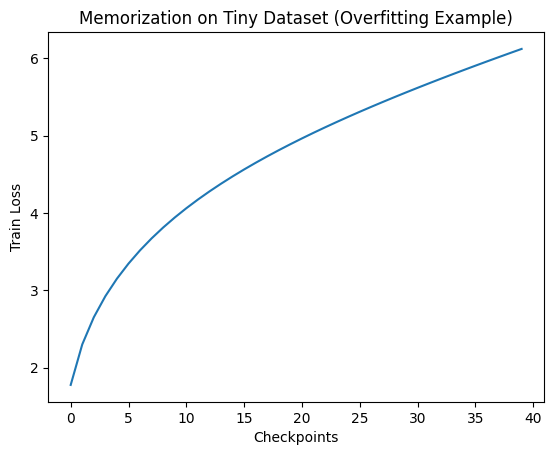

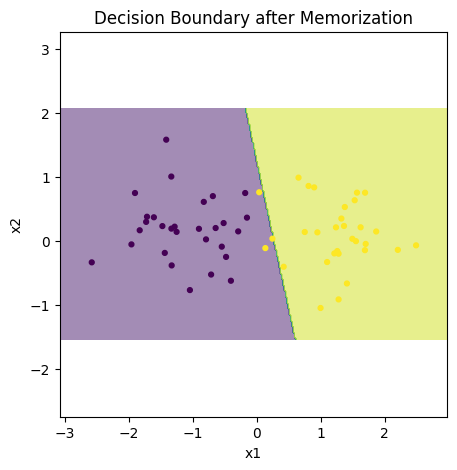

Train acc: 1.0
Val acc: 0.95


In [10]:

# We'll show a high-capacity network memorizing a tiny dataset
X, y = make_blobs(n_samples=120, centers=2, spread=0.3)
Xtr, ytr, Xva, yva = train_val_split(X, y, val_ratio=0.5, seed=99)

net_small = MLP(2, 128, 128, 1, act='tanh', init='xavier', seed=0)
losses = []
for t in range(2000):
    yhat, cache = net_small.forward(Xtr)
    loss = net_small.loss(ytr, yhat, l2=0.0)
    grads = net_small.backward(cache, ytr, l2=0.0)
    net_small.step(grads, lr=0.05)
    if (t+1) % 50 == 0:
        losses.append(loss)

plt.figure()
plt.plot(losses)
plt.title("Memorization on Tiny Dataset (Overfitting Example)")
plt.xlabel("Checkpoints"); plt.ylabel("Train Loss")
plt.show()

plot_decision_boundary(lambda Z: (net_small.forward(Z)[0].ravel() > 0.5).astype(int),
                       Xva, yva, title="Decision Boundary after Memorization")
print("Train acc:", accuracy_binary(ytr, net_small.forward(Xtr)[0]))
print("Val acc:", accuracy_binary(yva, net_small.forward(Xva)[0]))


## 11) Appendix: Gradient Derivations <a id='appendix'></a>

### Logistic Regression
For  
$$
z = w^\top x + b, \quad \hat{y} = \sigma(z) = \frac{1}{1 + e^{-z}},
$$  
and the binary cross-entropy loss  
$$
\ell = -\Big[y \log(\hat{y}) + (1 - y)\log(1 - \hat{y})\Big],
$$  
the derivatives are:  
$$
\frac{\partial \ell}{\partial z} = \hat{y} - y, \qquad
\frac{\partial \ell}{\partial w} = (\hat{y} - y)x, \qquad
\frac{\partial \ell}{\partial b} = \hat{y} - y.
$$  
If averaged over a batch of size $N$, divide each term by $N$.

---

### Backpropagation for a Hidden Layer
Let  
$$
h = f(u), \quad u = W x + b,
$$  
and let $\delta = \frac{\partial \ell}{\partial h}$ be the upstream gradient from the next layer.  
Then  
$$
\frac{\partial \ell}{\partial u} = \delta \odot f'(u), \qquad
\frac{\partial \ell}{\partial W} = (\delta \odot f'(u))\,x^\top, \qquad
\frac{\partial \ell}{\partial b} = \delta \odot f'(u).
$$

---

### Softmax (Multi-Class Case)
The softmax function is  
$$
\mathrm{softmax}(z)_k = \frac{e^{z_k}}{\sum_j e^{z_j}},
$$  
and with cross-entropy loss  
$$
\ell = -\sum_k y_k \log(\hat{y}_k),
$$  
the gradient at the logits is simply  
$$
\frac{\partial \ell}{\partial z_k} = \hat{y}_k - y_k,
$$  
where $y$ is a one-hot vector of true labels.

---

✅ These results come directly from the **chain rule** and the analytical derivatives of the **sigmoid** and **softmax** functions.